# NLP 2-AIML Capstone Grp 8

In this notebook we used LSTM+ XGBoost to predict the accident level.

This happens in 2 stages.
1. Process the description using 300d glove embeddings and pass them to LSTM for accident class probabilities.
2. Pass the probabilities along with other Non text parameters to XGBoost machine learning model to predict the final outcome.

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import Model, Sequential
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem,punkt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import lightgbm as lgb
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')


Output hidden; open in https://colab.research.google.com to view.

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Setting the current working directory

import os; 
os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone/Final')


In [4]:
import pandas as pd
#ram 
#data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv")
#satya path /content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv
data_orig = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv")
# pd.read_csv("/content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv") #regular
#smote data load below 
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/Final/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_SMOTE.csv")
data.head(3)


,Unnamed: 0,Data,Countries,Local,Industry Sector,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Accident Level
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,I


In [5]:
data_orig.shape

(425, 11)

In [6]:
data_bkp = data.copy()

In [7]:
data.rename(columns=
            {'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)


In [8]:
data_orig.rename(columns=
            {'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)


In [9]:
data.head(2)

,Unnamed: 0,Date,Countries,Local,Industry,Potential_Accident,Gender,Emp_Type,Critical Risk,Description,Accident
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I


## Target

In [10]:
risk_grade = {'I':0,'II':1,'III':2,'IV':3,'V':4,'VI':5}
data['Accident'] = pd.Series([risk_grade[x] for x in data['Accident']], index=data.index)


In [11]:
data['Accident']

0       0
1       0
2       0
3       0
4       3
       ..
1575    4
1576    4
1577    4
1578    4
1579    4
Name: Accident, Length: 1580, dtype: int64

In [12]:
data_orig['Accident']= pd.Series([risk_grade[x] for x in data_orig['Accident']], index=data_orig.index)

In [13]:
data_orig['Accident']

0      0
1      0
2      0
3      0
4      3
      ..
420    0
421    0
422    0
423    0
424    0
Name: Accident, Length: 425, dtype: int64

In [14]:
y=data['Accident']
y_orig=data['Accident']

In [15]:
data_x = data.drop(columns ='Accident',axis =1)

## Test train split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data_x, y, 
    test_size=0.2, random_state=1)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.3, random_state=0)

In [18]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(884, 10) (884,) (380, 10) (380,) (316, 10) (316,)


In [19]:
data_x_orig = data_orig.drop(columns ='Accident',axis =1)
y_orig=data_orig['Accident']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    data_x_orig, y_orig, 
    test_size=0.2, random_state=1)
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_train_orig, y_train_orig, 
    test_size=0.3, random_state=0)
print(X_train_orig.shape,y_train_orig.shape,X_val_orig.shape,y_val_orig.shape,X_test_orig.shape,y_test_orig.shape)

(238, 10) (238,) (102, 10) (102,) (85, 10) (85,)


# Preprocessing

## Text transformation

In [20]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	#print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	#print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	#print(df.new_col_name[0])

	#print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	#print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	#print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	#print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	#print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	#print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	#print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	#print('--'*30)
	return(df.new_col_name)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Date Transformation

In [21]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class TemporalVariableEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()

        X['month'] = pd.DatetimeIndex(X[self.variables]['Date']).month
        X['year'] = pd.DatetimeIndex(X[self.variables]['Date']).year
        X['day'] = pd.DatetimeIndex(X[self.variables]['Date']).day
#        X['dayname'] = pd.DatetimeIndex(X[self.variables]['Date']).day_name()
        X['weekofyear'] = pd.Int64Index(pd.DatetimeIndex(X[self.variables]['Date']).isocalendar().week)  

        enc_attribs=["month", "year", "day","weekofyear"]
        X=X.loc[:,enc_attribs]

        return X

## Text tokenization and impute

1.   Risk Category
2.   Industry



In [22]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class ImputeEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            ##print(X.info())
            ## Lable encoder
            industry = {'Metals':1,'Mining':2,'Others':99}
            X['Industry'] = pd.Series([industry[x] for x in X['Industry']], index=X.index)

            #print('Industry Encoded')
            
            risk_map = {'\nNot applicable': 99,
            'Bees': 1,
            'Venomous Animals': 1,
            'Blocking and isolation of energies': 3,
            'Burn': 3,
            'Confined space': 3,
            'Cut': 3,
            'Machine Protection': 3,
            'Manual Tools': 3,
            'Poll': 3,
            'Projection': 3,
            'Projection of fragments': 3,
            'Projection/Burning': 3,
            'Projection/Choco': 3,
            'Projection/Manual Tools': 3,
            'remains of choco': 3,
            'Suspended Loads': 3,
            'Fall': 4,
            'Fall prevention': 4,
            'Fall prevention (same level)': 4,
            'Electrical installation': 5,
            'Electrical Shock': 5,
            'Plates': 5,
            'Power lock': 5,
            'Chemical substances': 6,
            'Liquid Metal': 7,
            'Pressed': 8,
            'Pressurized Systems': 8,
            'Pressurized Systems / Chemical Substances': 8,
            'Individual protection equipment': 9,
            'Traffic': 10,
            'Vehicles and Mobile Equipment': 11,
            'Others': 99}

            X['Critical Risk'] = pd.Series([risk_map[x] for x in X['Critical Risk']], index=X.index)

 
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
           #print("Cleaned_Description",X_desc.head())
            from tensorflow.keras.preprocessing.text import Tokenizer
            tokenizer = Tokenizer (num_words = 100)
            tokenizer.fit_on_texts(list(X_desc))
            X_desc = tokenizer.texts_to_sequences(X_desc)

            max_len=100
           #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X_final = pd.DataFrame(X_pad)

            riskpred_model = 'predict_risk.pkl'
            riskpred_model = pickle.load(open(riskpred_model, 'rb'))
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
            #print("predictions",X[0])
           #print("predictions",X_processed_pca.shape)
            X['predicted_risk'] = riskpred_model.predict(X_processed_pca)
            X['predicted_risk'] = X.apply(lambda x: x['predicted_risk'] if x['Critical Risk']==99 else x['Critical Risk'], axis=1)
         
            X_pred_risk = X['predicted_risk'].values
           #print('predicted  risk values shape1',X_pred_risk.shape)             
            X_pred_risk = X_pred_risk.reshape(X_pred_risk.shape[0],1)

            #print('Risk Category imputation complete.')
            #print('predicted  risk shape2',X_pred_risk.shape)
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
##
           
            indpred_model = 'predict_industry.pkl'
            indpred_model = pickle.load(open(indpred_model, 'rb'))
            X['predicted_ind'] = indpred_model.predict(X_processed_pca)
            X['predicted_ind'] = X.apply(lambda x: x['predicted_ind'] if x['Industry']==99 else x['Industry'], axis=1)
           #print('predicted ind',X['predicted_ind'])
            #print("new",Y.info())
           #print(X.tail(20))
            X_pred_ind = X['predicted_ind'].values
            X_pred_ind = X_pred_ind.reshape(X_pred_ind.shape[0],1)

            #print('Industry imputation complete.')

           #print('predicted shape',X_pred_ind.shape)
           ##print('padded X_pad',X_pad.type())
            X_final['pred_risk'] = X_pred_risk
            X_final['pred_ind'] = X_pred_ind
            X = X_final
           #print(X_final.shape)
            return X

## Column Encoder

1. Country
2. Local
3. Emp_Type
4. Potential Accident

In [23]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class ColumnsLabelEncoder(BaseEstimator, TransformerMixin):
      
    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
       
        country = {'Country_01':1,'Country_02':2,'Country_03':3}
      
        local = { 'Local_01': 1,
                  'Local_02': 2,
                  'Local_03': 3,
                  'Local_04': 4,
                  'Local_05': 5,
                  'Local_06': 6,
                  'Local_07': 7,
                  'Local_08': 8,
                  'Local_09': 9,
                  'Local_10': 10,
                  'Local_11': 11,
                  'Local_12': 12 }

        emp = {
                  'Third Party': 1,
                  'Employee': 2,
                  'Third Party (Remote)': 3
        }
        
        risk_grade = {'I':1,'II':2,'III':3,'IV':4,'V':5,'VI':6}        
        

        X['Countries'] = pd.Series([country[x] for x in X['Countries']], index=X.index)
        #print('Countries Encoded')

        X['Local'] = pd.Series([local[x] for x in X['Local']], index=X.index)
        #print('Local Encoded')

        X['Emp_Type'] = pd.Series([emp[x] for x in X['Emp_Type']], index=X.index)
        #print('Emp_type Encoded')

        X['Potential_Accident'] = pd.Series([risk_grade[x] for x in data['Potential_Accident']], index=data.index)
        #print('Potential Accident Encoded')

        return X

## Pipeline

In [24]:
#Building the Transformation Pipeline
from sklearn.pipeline import Pipeline
from  sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
import numpy as np
#import skmice
dataframe=data
dataframe_x=dataframe.drop(['Accident'],axis=1)


#date pipeline##################################################
date_attribs=["Date"]
dataframe_date=dataframe.loc[:,date_attribs]
##print("dataframe_date chk" ,dataframe_date.head())
date_pipeline= Pipeline([('date_info_split', TemporalVariableEstimator(date_attribs))])
dataframe_date_tr=date_pipeline.fit_transform(dataframe_date)
#print("Date Pipeline check",dataframe_date_tr)
######################################################################

#OnehotEncoding Pipeline##############################################
#one_hot_attribs=["Local", "Industry", "Emp_Type","Countries","Potential_Accident","Gender"]
one_hot_attribs=["Gender"]
dataframe_onehot=dataframe.loc[:,one_hot_attribs]
#print("Onehot dataframe chk",dataframe_onehot.head())
one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
#one_hot_pipeline= Pipeline([('one_hot_encoder',LabelEncoder())])
dataframe_oh_tr=one_hot_pipeline.fit_transform(dataframe_onehot)
##print("Onehot Pipeline check",dataframe_oh_tr[0,1])

#Risk Pipeline##############################################
risk_attribs=['Critical Risk','Industry','Description']
dataframe_risk_imp=dataframe.loc[:,risk_attribs]
#print("Impute  dataframe chk",dataframe_risk_imp.head())
risk_pipeline= Pipeline([('risk_imputer',ImputeEstimator())])
dataframe_risk_imp_tr=risk_pipeline.fit_transform(dataframe_risk_imp)
#print("Impute Pipeline check",dataframe_risk_imp_tr[0])


#Lable encoder Pipeline##############################################
le_attribs=['Countries','Local','Emp_Type','Potential_Accident']
dataframe_le=dataframe.loc[:,le_attribs]
#print("LE  dataframe chk",dataframe_le.head())
le_pipeline= Pipeline([('risk_imputer',ColumnsLabelEncoder())])
dataframe_le_tr=le_pipeline.fit_transform(dataframe_le)
#print("LE Pipeline check",dataframe_le_tr[0:])

In [25]:
######################################################################
full_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",risk_pipeline, risk_attribs),
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs)
])
#dataframe_x_tr=full_pipeline.fit_transform(dataframe_x)
#dataframe_x_tr[0,:]


# LSTM Model

## TextEstimator
Class that Tokenizes and pads the description to 100 characters 

In [26]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class TextEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            #print("X['Description']:",X['Description'])
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
            #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 2000)
            tokenizer.fit_on_texts(list(X_desc))
            #print ("#############tokenizer.word_index",tokenizer.word_index)
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print("Tokenized",X_desc)
            max_len=100
            #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X = pd.DataFrame(X_pad)
            #print("X.shape **********",X.shape)
            #print(X.head(2))
            return X

In [44]:
#testing the text Pipeline##############################################
text_attribs=['Description']
dataframe_text=data.loc[:,text_attribs][0:2]
print("text  dataframe chk",dataframe_text.head())
text_pipeline= Pipeline([('text pipeline',TextEstimator())])
#dataframe_text_tr=text_pipeline.fit_transform(dataframe_text)
#print("Text Pipeline check",dataframe_text_tr)

text  dataframe chk                                          Description
0  While removing the drill rod of the Jumbo 08 f...
1  During the activation of a sodium sulphide pum...


## OnlyImputeEstimator
class that imputes the Industry and critical risk based on the description 

In [27]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class OnlyImputeEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            ##print(X.info())
            ## Lable encoder
            industry = {'Metals':1,'Mining':2,'Others':99}
            X['Industry'] = pd.Series([industry[x] for x in X['Industry']], index=X.index)

            #print('Industry Encoded')
            
            risk_map = {'\nNot applicable': 99,
            'Bees': 1,
            'Venomous Animals': 1,
            'Blocking and isolation of energies': 3,
            'Burn': 3,
            'Confined space': 3,
            'Cut': 3,
            'Machine Protection': 3,
            'Manual Tools': 3,
            'Poll': 3,
            'Projection': 3,
            'Projection of fragments': 3,
            'Projection/Burning': 3,
            'Projection/Choco': 3,
            'Projection/Manual Tools': 3,
            'remains of choco': 3,
            'Suspended Loads': 3,
            'Fall': 4,
            'Fall prevention': 4,
            'Fall prevention (same level)': 4,
            'Electrical installation': 5,
            'Electrical Shock': 5,
            'Plates': 5,
            'Power lock': 5,
            'Chemical substances': 6,
            'Liquid Metal': 7,
            'Pressed': 8,
            'Pressurized Systems': 8,
            'Pressurized Systems / Chemical Substances': 8,
            'Individual protection equipment': 9,
            'Traffic': 10,
            'Vehicles and Mobile Equipment': 11,
            'Others': 99}

            X['Critical Risk'] = pd.Series([risk_map[x] for x in X['Critical Risk']], index=X.index)

            #print('Critical Risk Encoded')

            #Y = X.copy()
           #print("X['Description']:",X['Description'])
            #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
           #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 100)
            tokenizer.fit_on_texts(list(X_desc))
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print('Cleaned text Tokenized.')

           #print("Tokenized",X_desc)
            #max_len=max( X['cleaned_Description'].apply(lambda x: len(x.split(' '))))
            max_len=100
           #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X_final = pd.DataFrame(X_pad)
  #         #print("padded",X_pad[0,:])
            #print(text_encoded.head())
            #X = X[X['Critical Risk'] == 99]
            #print(X.shape)
            riskpred_model = 'predict_risk.pkl'
            riskpred_model = pickle.load(open(riskpred_model, 'rb'))
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
            #print("predictions",X[0])
           #print("predictions",X_processed_pca.shape)
            X['predicted_risk'] = riskpred_model.predict(X_processed_pca)
            X['predicted_risk'] = X.apply(lambda x: x['predicted_risk'] if x['Critical Risk']==99 else x['Critical Risk'], axis=1)
            #print("new",Y.info())
           #print(X.head())
          # #print('predicted  risk shape1',X_pred_risk.shape)            
            X_pred_risk = X['predicted_risk'].values
           #print('predicted  risk values shape1',X_pred_risk.shape)             
            #X_pred_risk = X_pred_risk.reshape(X_pred_risk.shape[0],1)

            print('Risk Category imputation complete.')
            #print('predicted  risk shape2',X_pred_risk.shape)
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
##
           
            indpred_model = 'predict_industry.pkl'
            indpred_model = pickle.load(open(indpred_model, 'rb'))
            X['predicted_ind'] = indpred_model.predict(X_processed_pca)
            X['predicted_ind'] = X.apply(lambda x: x['predicted_ind'] if x['Industry']==99 else x['Industry'], axis=1)
           #print('predicted ind',X['predicted_ind'])
            #print("new",Y.info())
           #print(X.tail(20))
            X_pred_ind = X['predicted_ind'].values
            #X_pred_ind = X_pred_ind.reshape(X_pred_ind.shape[0],1)

            #print('Industry imputation complete.')

           #print('predicted shape',X_pred_ind.shape)
           ##print('padded X_pad',X_pad.type())
            X_final=pd.DataFrame()
            #print('X_pred_risk shape',X_pred_risk.shape)
            #print('X_pred_ind shape',X_pred_ind.shape)
            X_final['pred_risk'] = X_pred_risk
            X_final['pred_ind'] = X_pred_ind
            X = X_final
           #print(X_final.shape)
            return X

## Non text pipeline
pipeline that preprocesses all the columns except description - performs - date column transformation, Imputation of Risk and Industry, one ot encodes the gender columns and label encodes all other categorical columns

In [29]:
#Testing the OnlyImpue Estimator Pipeline##############################################
impute_attribs=['Critical Risk','Industry','Description']
dataframe_risk_imp=dataframe.loc[:,impute_attribs]
impute_pipeline= Pipeline([('imputer',OnlyImputeEstimator())])
#dataframe_risk_imp_tr=impute_pipeline.fit_transform(dataframe_risk_imp)
#print(dataframe_risk_imp_tr)

In [30]:
######################################################################
all_attribs=date_attribs+impute_attribs+one_hot_attribs+le_attribs
non_text_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",impute_pipeline, impute_attribs),
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs)
])


## Creating the embedding matrix

In [31]:
max_features = 10000
maxlen = 300
embedding_size = 300

In [32]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(clean_text(data,"Description")))

In [33]:
data['Cleaned_Description'] = clean_text(data,"Description")

In [34]:
data_orig['Cleaned_Description'] = clean_text(data_orig,"Description")

In [37]:
X_orig = tokenizer.texts_to_sequences(data['Cleaned_Description'])
X_orig = pad_sequences(X_orig, maxlen = maxlen)
y_orig = np.asarray(data['Accident'])

print(f'Number of Samples: {len(X_orig)}')
print(f'Number of Labels: {len(y_orig)}')
print(f'\nFirst headline:\n{X_orig[0]}\n\nLabel of the first headline: {y_orig[0]}')

Number of Samples: 1580
Number of Labels: 1580

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   

In [ ]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

In [36]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, maxlen))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [40]:
embedding_matrix.shape

(2745, 300)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,Flatten,Dropout
from tensorflow.keras.initializers import Constant

num_words = len(tokenizer.word_index) + 1
embed_dim = 300
lstm_out = 196
vocabSize=20000

model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length = maxlen, trainable = False))
#model.add(SpatialDropout1D(0.3))
model.add(Dense(64,activation='tanh'))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
#model.add(Dense(126,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(10,activation='tanh'))
##model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(5,activation='softmax'))

In [42]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          823500    
_________________________________________________________________
dense (Dense)                (None, 300, 64)           19264     
_________________________________________________________________
bidirectional (Bidirectional (None, 392)               409248    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3930      
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 1,255,997
Trainable params: 432,497
Non-trainable params: 823,500
__________________________________________

In [45]:
X_train_orig_text=text_pipeline.fit_transform(X_train_orig)
print(X_train_orig_text.shape)
X_val_orig_text=text_pipeline.fit_transform(X_val_orig)
print(X_val_orig_text.shape)
X_test_orig_text=text_pipeline.fit_transform(X_test_orig)

(238, 100)
(102, 100)


In [46]:
X_train_text=text_pipeline.fit_transform(X_train)
X_val_text=text_pipeline.fit_transform(X_val)
X_test_text=text_pipeline.fit_transform(X_test)

In [47]:
# Use earlystopping
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
#callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=0.01)
batch_size=32
es=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)
mc = ModelCheckpoint('lstm_model_pred.h5'
                , monitor = 'val_loss'
                , mode = 'min', save_best_only = True, verbose = 1) 
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, patience = 5)  
callbacks = [es, mc, lr_r  ]

# Fit the model
history=model.fit(X_train_orig_text,y_train_orig, validation_data=(X_val_orig_text, y_val_orig), epochs=10, batch_size=batch_size, callbacks=callbacks)

Epoch 1/10
8/8 [==============================] - 12s 813ms/step - loss: 1.3728 - accuracy: 0.5083 - val_loss: 1.0210 - val_accuracy: 0.7549

Epoch 00001: val_loss improved from inf to 1.02103, saving model to lstm_model_pred.h5
Epoch 2/10
8/8 [==============================] - 6s 735ms/step - loss: 0.9433 - accuracy: 0.7288 - val_loss: 0.9114 - val_accuracy: 0.7549

Epoch 00002: val_loss improved from 1.02103 to 0.91140, saving model to lstm_model_pred.h5
Epoch 3/10
8/8 [==============================] - 6s 726ms/step - loss: 0.9622 - accuracy: 0.7042 - val_loss: 0.9085 - val_accuracy: 0.7549

Epoch 00003: val_loss improved from 0.91140 to 0.90846, saving model to lstm_model_pred.h5
Epoch 4/10
8/8 [==============================] - 6s 753ms/step - loss: 0.8580 - accuracy: 0.7547 - val_loss: 0.9029 - val_accuracy: 0.7549

Epoch 00004: val_loss improved from 0.90846 to 0.90286, saving model to lstm_model_pred.h5
Epoch 5/10
8/8 [==============================] - 6s 757ms/step - loss: 0.8

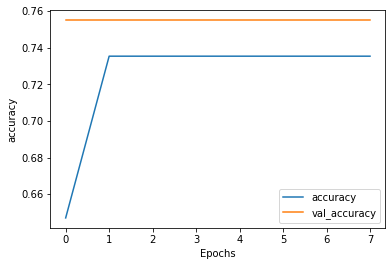

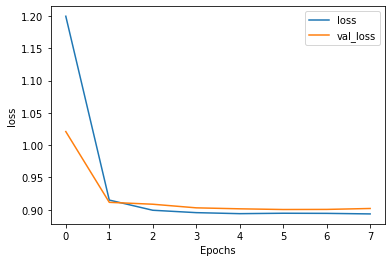

In [48]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
graph_plots(history, "accuracy")
graph_plots(history, "loss")

## Exporting LSTM best model and weights

In [49]:
! pip install h5py

In [50]:
# serialize lstm_pred_model to JSON
lstm_pred_model=model
lstm_pred_model_json = lstm_pred_model.to_json()
with open("lstm_pred_model.json", "w") as json_file:
    json_file.write(lstm_pred_model_json)
# serialize weights to HDF5
lstm_pred_model.save_weights("lstm_pred_model.h5")
print("Saved lstm_pred_model to disk")

Saved lstm_pred_model to disk


## Testing loaded LSTM model

In [51]:
# load json and create lstm_pred_model
from keras.models import model_from_json
json_file = open('lstm_pred_model.json', 'r')
loaded_lstm_pred_model_json = json_file.read()
json_file.close()
loaded_lstm_pred_model = model_from_json(loaded_lstm_pred_model_json)
# load weights into new lstm_pred_model
loaded_lstm_pred_model.load_weights("lstm_pred_model.h5")
print("Loaded lstm_pred_model from disk")

Loaded lstm_pred_model from disk


In [52]:
from sklearn.metrics import classification_report
y_predict= loaded_lstm_pred_model.predict(X_test_text,batch_size=1)

In [53]:
y_predict

array([[0.7360856 , 0.09914375, 0.06995252, 0.08446618, 0.01035205],
       [0.73584485, 0.09891737, 0.07022069, 0.08457354, 0.01044356],
       [0.7401639 , 0.0984124 , 0.06672731, 0.08471232, 0.00998401],
       ...,
       [0.73862255, 0.09871414, 0.0679304 , 0.08461495, 0.01011797],
       [0.73705816, 0.09858814, 0.0692891 , 0.08469748, 0.01036709],
       [0.7353539 , 0.09921527, 0.07054844, 0.08445185, 0.01043059]],
      dtype=float32)

In [54]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class LstmModelPredictions(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            #print("X['Description']:",X['Description'])
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
            #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 2000)
            tokenizer.fit_on_texts(list(X_desc))
            #print ("#############tokenizer.word_index",tokenizer.word_index)
            X_desc = tokenizer.texts_to_sequences(X_desc)
            #print("Tokenized",X_desc)
            max_len=100
            #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            #Import the lstm pred model
            from keras.models import model_from_json
            json_file = open('lstm_pred_model.json', 'r')
            loaded_lstm_pred_model_json = json_file.read()
            json_file.close()
            loaded_lstm_pred_model = model_from_json(loaded_lstm_pred_model_json)
            # load weights into new lstm_pred_model
            loaded_lstm_pred_model.load_weights("lstm_pred_model.h5")
            print("Loaded lstm_pred_model from disk")
            lstm_predictions = loaded_lstm_pred_model.predict(X_pad)
            X = pd.DataFrame(lstm_predictions)
            #print("X.shape **********",X.shape)
            #print(X.head(2))
            return X

In [55]:
#LSTM Preds Pipeline##############################################
lstm_attribs=['Description']
df_lstm_preds=dataframe.loc[:,lstm_attribs]
lstm_preds_pipeline= Pipeline([('Get LSTM Model predictions',LstmModelPredictions())])
df_lstm_preds_tr=lstm_preds_pipeline.fit_transform(df_lstm_preds)
#print(df_lstm_preds_tr)

Loaded lstm_pred_model from disk


In [57]:
lstm_full_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",risk_pipeline, risk_attribs),
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs),
                ("LSTM prediction",lstm_preds_pipeline, ['Description']),
 ])

In [58]:
#LSTM full Pipeline##############################################
X_train_tr=lstm_full_pipeline.fit_transform(X_train)
X_val_tr=lstm_full_pipeline.fit_transform(X_val)
X_test_tr=lstm_full_pipeline.fit_transform(X_test)

Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk


In [59]:
X_train_tr.shape

(884, 116)

In [60]:
X_train

,Unnamed: 0,Date,Countries,Local,Industry,Potential_Accident,Gender,Emp_Type,Critical Risk,Description
277,277,2016-12-23 00:00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,When performing the movement of the bar to mak...
1312,1312,2017-03-31 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party,Plates,During the withdrawal of the metal form suppor...
886,886,2017-03-25 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Manual Tools,During the withdrawal the Kelly bar (conductiv...
357,357,2017-03-18 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party (Remote),Power lock,During the activity of changing conveyor belt ...
1141,1141,2016-06-08 00:00:00,Country_02,Local_08,Mining,IV,Male,Third Party,Fall prevention,During the change of rim position 1 of the Jum...
...,...,...,...,...,...,...,...,...,...,...
1487,1487,2017-03-10 00:00:00,Country_01,Local_01,Mining,V,Male,Third Party,Suspended Loads,When the mechanical technician proceeded to pe...
501,501,2017-05-19 00:00:00,Country_01,Local_02,Mining,III,Male,Employee,Power lock,The worker Manuel was making the disconnection...
542,542,2017-06-22 00:00:00,Country_01,Local_01,Mining,III,Male,Employee,Others,The industrial cleaning worker Cristian was pe...
978,978,2017-01-07 00:00:00,Country_01,Local_05,Metals,III,Male,Employee,Cut,"At 14: 55h on 27 September, a worker from Conf..."


# Comparing LSTM+ Machine learning classifiers

In [61]:
# Compare Algorithms for full data
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
import xgboost as xgb
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('BR', BaggingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SVM', SVC(kernel='rbf')))
models.append(('NB',GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train_tr, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

BR: 0.634617 (0.020034)
XGB: 0.661762 (0.027796)
RF: 0.618817 (0.051833)
CART: 0.583719 (0.036442)
GB: 0.666301 (0.026594)
SVM: 0.186640 (0.017744)
NB: 0.427562 (0.021757)


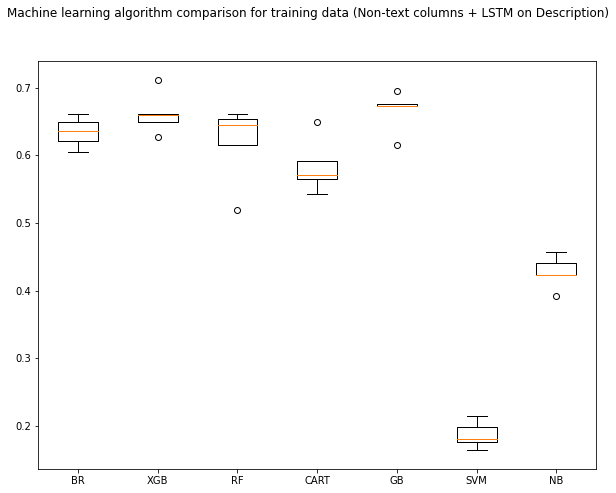

In [62]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,7.5))
fig.suptitle('Machine learning algorithm comparison for training data (Non-text columns + LSTM on Description)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# LSTM +XGBoost

In [63]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
seed=42
xgb_pipe_steps = [('lstm_full_pipeline',lstm_full_pipeline),
                  ('scaler',StandardScaler()),
                 ('XGB', xgb.XGBClassifier(random_state=seed ))
            ]

check_params= {
    'XGB__max_depth': [6,7], 
    'XGB__min_child_weight' : [2,3],
    'XGB__n_estimators' : [100],
    'XGB__eta' : [0.003],
    'XGB__learning_rate' : [0.04,0.05],
}
xgb_pipeline = Pipeline(xgb_pipe_steps)

In [64]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(xgb_pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)
    lstm_xgb_best_model=create_grid.best_estimator_
    print("LSTM+ XGB Best Model :",lstm_xgb_best_model)
  

print ("out of the loop")

Start Fitting Training Data


Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lstm_pred_model from disk
Loaded lst

## Export best model to pickle

In [65]:
import pickle
from pickle import dump
dump(lstm_xgb_best_model, open('lstm_xgb_lstm_full_model.pkl', 'wb'))

## Test loaded model

In [66]:
print(X_test.shape)
# X_test_tr=lstm_full_pipeline.fit_transform(X_test)
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
lstm_pred = lstm_pred_model.predict(X_test)
print(lstm_pred)

(316, 10)
Loaded lstm_pred_model from disk
[2 3 4 0 0 4 0 2 3 1 0 0 4 4 3 3 0 1 2 0 4 0 3 3 0 3 4 4 0 3 0 0 3 3 1 2 1
 0 2 3 3 1 1 1 2 3 4 4 4 1 0 1 3 4 0 4 1 4 0 3 3 4 1 4 4 4 4 4 0 2 1 3 3 3
 3 1 4 4 2 4 4 0 3 3 1 3 2 1 3 3 0 1 3 3 4 0 3 1 1 0 1 2 1 0 3 4 1 3 2 3 0
 4 2 0 4 4 3 2 2 4 3 3 1 3 3 0 3 3 0 1 3 0 1 4 0 4 1 4 3 2 0 3 4 3 0 4 2 0
 3 0 4 3 0 3 3 3 3 0 1 3 2 1 3 3 1 4 3 3 3 1 2 2 3 1 2 0 3 4 3 3 4 4 4 2 4
 4 3 4 4 4 2 0 2 1 3 0 0 3 3 0 2 1 1 2 2 0 1 2 4 3 4 2 1 0 1 2 4 0 2 4 4 3
 2 3 4 1 4 0 0 1 0 2 2 1 3 4 4 1 4 3 3 1 3 3 3 0 3 3 4 3 4 3 3 4 4 4 2 4 3
 4 2 0 1 2 2 3 1 0 3 4 4 0 3 2 4 3 3 4 3 1 1 4 4 0 4 3 4 0 4 0 3 2 4 2 3 4
 1 1 3 3 2 1 2 2 2 0 3 4 4 4 3 0 3 3 4 1]


In [67]:
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
lstm_pred = lstm_pred_model.predict(X_test)  

Loaded lstm_pred_model from disk


In [68]:
import pickle
lstm_pred_model = pickle.load(open('lstm_xgb_lstm_full_model.pkl', 'rb'))
#lstm_pred = lstm_pred_model.predict(X_test)
print(lstm_pred_model)

Pipeline(memory=None,
         steps=[('lstm_full_pipeline',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',
                                                  Pipeline(memory=None,
                                                           steps=[('risk_imputer',
                                                              

In [69]:
print(accuracy_score(y_test,lstm_pred))

0.6645569620253164


# LSTM+ XGBoost classification report

In [70]:
from sklearn.metrics import classification_report
print (classification_report(y_test, lstm_pred_model.predict(X_test)))

Loaded lstm_pred_model from disk
              precision    recall  f1-score   support

           0       0.76      0.59      0.66        70
           1       0.67      0.49      0.56        68
           2       0.48      0.47      0.47        45
           3       0.50      0.72      0.59        64
           4       0.90      1.00      0.95        69

    accuracy                           0.66       316
   macro avg       0.66      0.65      0.65       316
weighted avg       0.68      0.66      0.66       316

